In [58]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True) # para usar latex en matplotlib

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import convolve
import time
import pickle
import numba 

In [133]:
def A_B(un, a, b, domain, dim, tau, kappa):
    K_dx_minus  = np.array([
        [0,  0, 0],
        [-1, 1, 0],
        [0,  0, 0]
    ])
    K_dx_plus  = np.array([
        [0,  0, 0],
        [0, -1, 1],
        [0,  0, 0]
    ])
    dx_minus = convolve(un.reshape(dim[0], dim[1]), K_dx_minus)
    dx_plus = convolve(un.reshape(dim[0], dim[1]), K_dx_plus)
    dy_minus = convolve(un.reshape(dim[0], dim[1]).T, -K_dx_plus).T
    dy_plus = convolve(un.reshape(dim[0], dim[1]).T, -K_dx_minus).T

    norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2+np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2+np.minimum(dy_plus, 0)**2) )
    norm_grad[0, :] = 0
    norm_grad[-1, :] = 0
    norm_grad[:, 0] = 0
    norm_grad[:, -1] = 0

    K_x_minus  = np.array([
            [0,  0, 0],
            [1, 1, 0],
            [0,  0, 0]
        ])
    K_x_plus  = np.array([
            [0,  0, 0],
            [0, 1, 1],
            [0,  0, 0]
        ])
    x_minus = convolve(norm_grad, K_x_minus)
    x_plus = convolve(norm_grad, K_x_plus)
    y_minus = convolve(norm_grad.T, K_x_plus).T
    y_plus = convolve(norm_grad.T, K_x_minus).T
    
    hm_x_minus = (2/x_minus) 
    hm_x_minus[np.isclose(norm_grad, 0)] = 0
    hm_x_plus = (2/x_plus) 
    hm_x_plus[np.isclose(norm_grad, 0)] = 0
    hm_y_minus = (2/y_minus) 
    hm_y_minus[np.isclose(norm_grad, 0)] = 0
    hm_y_plus = (2/y_plus) 
    hm_y_plus[np.isclose(norm_grad, 0)] = 0
    
    hm_sum = hm_x_minus + hm_x_plus + hm_y_minus + hm_y_plus
    
    get_sigma = - a.reshape((dim[0], dim[1])) * norm_grad * hm_sum
        
    def neighbours(p, l="x"):
        px, py = p
        if l == "x":
            o = [ (px, py-1), (px, py+1) ]
            
        elif l == "y":
            o = [ (px-1, py), (px+1, py) ]
            
        return [m  for m in o if m in domain]

    def get_delta(p, m):
        norm_grad_p = norm_grad[p]
        ix = domain.index(p)
        if np.isclose(norm_grad_p, 0):
            return 0
        else:
            d_p_m = [m[0]-p[0], m[1]-p[1]]
            if d_p_m[0] == 1:
                return a[ix] * norm_grad_p * hm_y_plus[p]
            if d_p_m[0] == -1:
                return a[ix] * norm_grad_p * hm_y_minus[p]
            if d_p_m[1] == 1:
                return a[ix] * norm_grad_p * hm_x_plus[p]
            if d_p_m[1] == -1:
                return a[ix] * norm_grad_p * hm_x_minus[p]  
    
    def get_A_row(row):
        px = row
        
        D   = get_sigma[px, :]

        D1  = [ get_delta( (px, c), (px, c+1) )  for c in range( dim[1] - 1 ) ]

        D_1 = [ get_delta( (px, c), (px, c-1) )  for c in range( 1, dim[1]  ) ]

        k = np.array([D_1, D, D1], dtype= object)
        offset = [-1, 0, 1]
        
        return diags(k, offset)
    
    def get_A_star_row(row, star):
        px = row
        
        D = [ get_delta( (px, c), (px+star, c) ) for c in range( dim[1] ) ]
        
        k = D
        offset = 0
        
        return diags(k, offset)
    
    D = [ get_A_row(row) for row in range( dim[0] ) ]                                                    
    D1 =  [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]
    D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]

    A0 = block_diag(D)
    A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
    A2 = csr_matrix(block_diag(D_1).todense()[:-dim[1],dim[1]:])
    
    I = csr_matrix(np.eye(un.shape[0]))
    A_star = I - tau * csr_matrix(A0+A1+A2)

    B_star = un + tau*kappa*np.ravel(norm_grad)*a

    return A_star, B_star, norm_grad
    

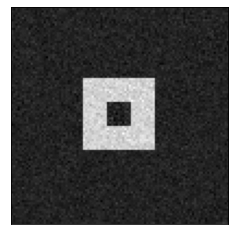

In [93]:
dim = (100, 100)
domain = [ 
    (x, y) for x in range( dim[0] ) for y in range( dim[1] )
]

img = np.random.normal(0.4, 0.005, size=dim[0] * dim[1])
for i in range(dim[0]//3):
    for j in range(dim[1]//3):
        img[(i+dim[0]//3)*dim[1]+j+dim[1]//3] += np.random.normal(0.1, 0.005)

for i in range(dim[0]//9):
    for j in range(dim[1]//9):
        img[(i+4*dim[0]//9)*dim[1]+j+4*dim[1]//9] -= np.random.normal(0.1, 0.005)

display(plt.imshow(img.reshape(dim[0], dim[1]), cmap='gray'))
plt.xticks([]);
plt.yticks([]);
# plt.savefig("img02.png", bbox_inches='tight')

In [88]:
def stopping_func(img, dim, domain, sgm=0.5, lmbd=1):
    blurred = gaussian_filter(img.reshape(dim[0], dim[1]), sigma=sgm).flatten()
    f_sgm = blurred
    
    norm_grad_f_sgm = []
    for ix in range(len(domain)):
        p = domain[ix]
        dx = 0
        dy = 0
        if p[1]<dim[1]-1:
            kx = domain.index((p[0], p[1]+1))
            dx = f_sgm[kx]-f_sgm[ix]
        if p[0]<dim[0]-1:
            kx = domain.index((p[0]+1, p[1]))
            dy = f_sgm[kx]-f_sgm[ix]

        val = np.sqrt( dx**2 + dy**2 ) 
        norm_grad_f_sgm.append(val)
    
    g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )
    
    return (g, blurred)

C:\Users\felip\AppData\Local\Temp/ipykernel_4284/838872357.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )
C:\Users\felip\AppData\Local\Temp/ipykernel_4284/838872357.py:20: RuntimeWarning: invalid value encountered in double_scalars
  g = np.array( [1/(1+((g_f**2)/(lmbd**2))) for g_f in norm_grad_f_sgm] )


Wall time: 51.5 s


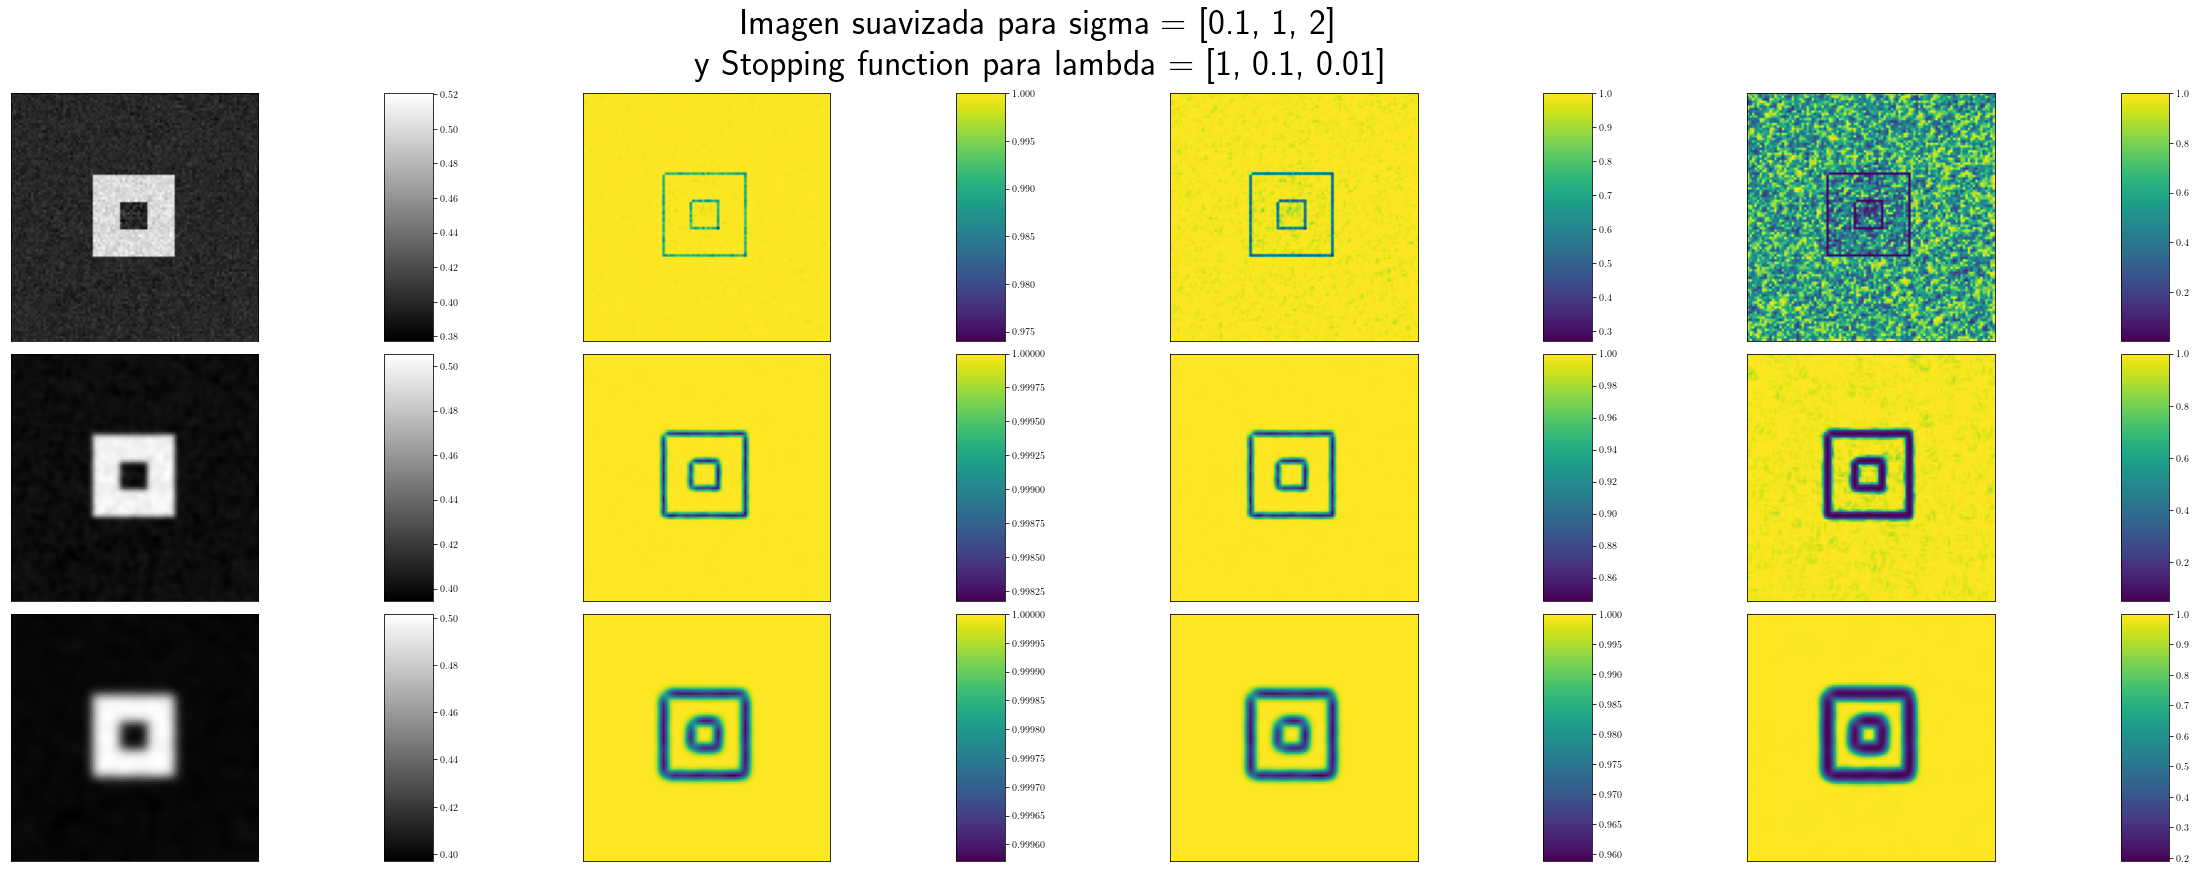

In [5]:
%%time
fig, ax = plt.subplots(3, 4*2, figsize=(4*2*4, 3*4), constrained_layout=True, 
                       gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1]})
for i, sgm in enumerate([0.1, 1, 2]):
    for j, lmbd in enumerate([0, 1, 0.1, 0.01]):
        g, blurred = stopping_func(img, dim, domain, sgm=sgm, lmbd=lmbd)
        if j == 0:
            im = ax[i, j*2].imshow(blurred.reshape(dim[0], dim[1]), cmap='gray')
        else:
            im = ax[i, j*2].imshow(g.reshape(dim[0], dim[1]))
        fig.colorbar(im, cax=ax[i, j*2+1], orientation='vertical')
        ax[i, j*2].set_xticks([])
        ax[i, j*2].set_yticks([])
plt.suptitle("Imagen suavizada para sigma = [0.1, 1, 2] \ny Stopping function para lambda = [1, 0.1, 0.01]", size=18*2)
plt.savefig("stopping_function2.png", bbox_inches='tight');

In [5]:
def initial_curve(x0, r, domain, dim):
    u0 = np.zeros(len(domain))
    for p in domain:
        x = (p[0]/(dim[0]-1), p[1]/(dim[1]-1))
        sgn = 0
        if (x[0]-x0[0]) ** 2 + (x[1]-x0[1]) ** 2 < r ** 2:
            sgn = 1
        else:
            sgn = -1
        dist = abs(r-linalg.norm([x[0]-x0[0], x[1]-x0[1]]))
        ix = domain.index(p)
        u0[ix] = sgn * dist
    return u0

Wall time: 891 ms


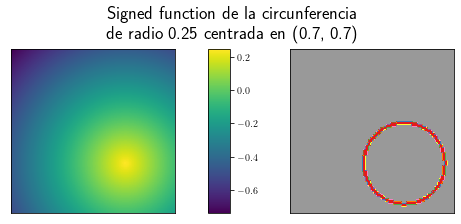

In [15]:
%%time
u0 = initial_curve((0.7, 0.7), 0.25, domain, dim)
fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
im = ax[0].imshow(u0.reshape(dim[0], dim[1]))
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(im, cax=ax[1], orientation='vertical')
cv0 = np.isclose(u0, 0, atol=0.01)
ax[2].imshow(cv0.reshape(dim[0], dim[1]), cmap="Set1_r")
ax[2].set_xticks([])
ax[2].set_yticks([]);
plt.suptitle("Signed function de la circunferencia \nde radio 0.25 centrada en (0.7, 0.7)", size=18)
# plt.tight_layout();
plt.savefig("u0.png", bbox_inches='tight');

<ipython-input-133-d3b3cd73f888>:38: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_minus = (2/x_minus)
<ipython-input-133-d3b3cd73f888>:40: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_plus = (2/x_plus)
<ipython-input-133-d3b3cd73f888>:42: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_minus = (2/y_minus)
<ipython-input-133-d3b3cd73f888>:44: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_plus = (2/y_plus)


Wall time: 16.8 s


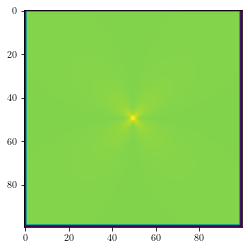

In [134]:
%%time
tau = 5
kappa=-0.1
a, img_blurred = stopping_func(img, dim, domain, sgm=1, lmbd=0.01)
b = np.ones( dim[0] * dim[1] )

u0 = initial_curve((0.5, 0.5), 0.3, domain, dim)

A0_star, B0_star, norm_grad = A_B(u0, a, b, domain, dim, tau, kappa)
plt.imshow(norm_grad)

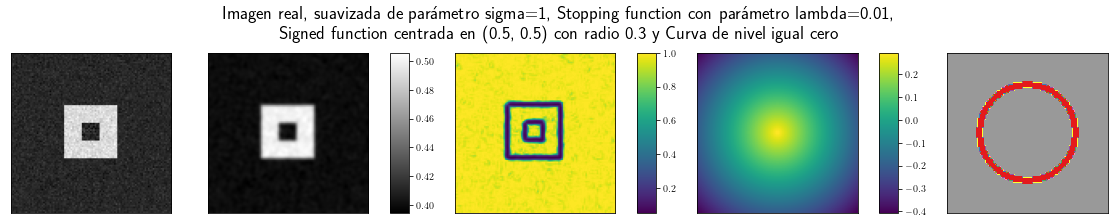

In [92]:
fig, ax = plt.subplots(1, 8, figsize=(5*3+3*0.25, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 1, 0.1, 1, 0.1, 1, 0.1, 1]})

ax[0].imshow(img.reshape(dim[0], dim[1]), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(img_blurred.reshape(dim[0], dim[1]), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([]);
fig.colorbar(im, cax=ax[2], orientation='vertical')

im = ax[3].imshow(a.reshape(dim[0], dim[1]))
ax[3].set_xticks([])
ax[3].set_yticks([]);
fig.colorbar(im, cax=ax[4], orientation='vertical')

im = ax[5].imshow(u0.reshape(dim[0], dim[1]))
ax[5].set_xticks([])
ax[5].set_yticks([])
fig.colorbar(im, cax=ax[6], orientation='vertical')

cv0 = np.isclose(u0, 0, atol=0.02)
ax[7].imshow(cv0.reshape(dim[0], dim[1]), cmap="Set1_r")
ax[7].set_xticks([])
ax[7].set_yticks([]);

plt.suptitle("Imagen real, suavizada de parámetro sigma=1, Stopping function con parámetro lambda=0.01, \nSigned function centrada en (0.5, 0.5) con radio 0.3 y Curva de nivel igual cero", size=18)
plt.savefig("init_exp5.png", bbox_inches='tight');

In [136]:
un = u0
iterations = [u0]
times = [0]

In [ ]:
%%time
for n in range(50):
    
    start = time.time()
    An_star, Bn_star, _ = A_B(un, a, b, domain, dim, tau, kappa)
    un1 = spsolve(An_star, Bn_star)
    cvn = np.isclose(un1, 0, atol=0.01)

    fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
    im = ax[0].imshow(un1.reshape(dim[0], dim[1]))
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);
    fig.colorbar(im, cax=ax[1], orientation='vertical')

    ax[2].imshow(cvn.reshape(dim[0], dim[1]), cmap="Set1_r")
    ax[2].set_xticks([]);
    ax[2].set_yticks([]);

    plt.savefig(f"image_test6/un_{n}.png", bbox_inches='tight');

    un = un1
    iterations.append(un)
    end = time.time()
    
    times.append(end-start)
    print("n:", n, "time:", times[-1])

<ipython-input-133-d3b3cd73f888>:38: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_minus = (2/x_minus)
<ipython-input-133-d3b3cd73f888>:40: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_plus = (2/x_plus)
<ipython-input-133-d3b3cd73f888>:42: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_minus = (2/y_minus)
<ipython-input-133-d3b3cd73f888>:44: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_plus = (2/y_plus)


n: 0 time: 12.40431022644043
n: 1 time: 13.780281066894531
n: 2 time: 13.210004091262817
n: 3 time: 13.50540018081665
n: 4 time: 13.550154685974121
n: 5 time: 12.196582794189453
n: 6 time: 13.077883958816528
n: 7 time: 13.344805240631104
n: 8 time: 13.191795825958252
n: 9 time: 12.058849573135376
n: 10 time: 12.856510639190674
n: 11 time: 12.392003536224365
n: 12 time: 13.137900352478027
n: 13 time: 13.631209135055542
n: 14 time: 12.681893110275269
n: 15 time: 12.11989140510559
n: 16 time: 12.139050722122192
n: 17 time: 12.230427742004395
n: 18 time: 11.871980905532837
n: 19 time: 11.986720561981201


<timed exec>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


n: 20 time: 12.886284112930298
n: 21 time: 13.692941188812256
n: 22 time: 13.029158353805542
n: 23 time: 12.649756669998169
n: 24 time: 12.563437938690186
n: 25 time: 12.450861692428589
n: 26 time: 12.779434204101562
n: 27 time: 12.76834225654602
n: 28 time: 13.076128959655762
n: 29 time: 12.699096202850342
n: 30 time: 12.84371829032898
n: 31 time: 12.665906429290771
n: 32 time: 12.94671082496643
n: 33 time: 12.862830400466919
n: 34 time: 13.262654304504395
n: 35 time: 14.328866243362427
n: 36 time: 13.585922479629517
n: 37 time: 13.161457300186157


In [42]:
pickle.dump(iterations, open("iterations0.pickle", "wb"))
pickle.dump(times, open("times0.pickle", "wb"))

mean: 35.06385461143825 std: 0.5625724966687793


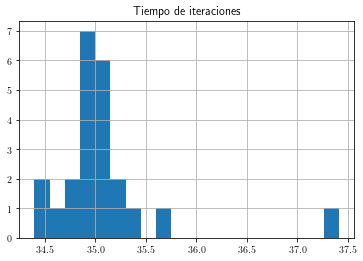

In [79]:
rel_times = times[1:23+1]
pd.DataFrame(rel_times, columns=["Tiempo de iteraciones"]).hist(bins=20);
print("mean:", np.mean(rel_times), "std:", np.std(rel_times))

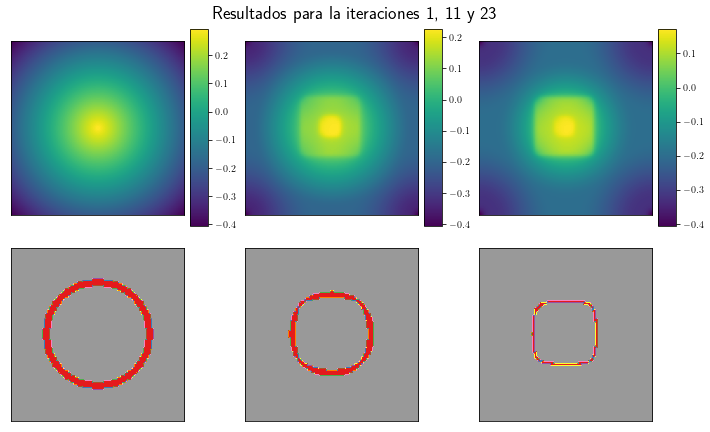

In [91]:
fig, ax = plt.subplots(2, 6, figsize=(3*3+3*0.25, 3*2), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1]})

# Funciones
im = ax[0, 0].imshow(iterations[0].reshape(dim[0], dim[1]))
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

fig.colorbar(im, cax=ax[0, 1], orientation='vertical')

im = ax[0, 2].imshow(iterations[11].reshape(dim[0], dim[1]))
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fig.colorbar(im, cax=ax[0, 3], orientation='vertical')

im = ax[0, 4].imshow(iterations[23].reshape(dim[0], dim[1]))
ax[0, 4].set_xticks([])
ax[0, 4].set_yticks([])

fig.colorbar(im, cax=ax[0, 5], orientation='vertical')

# Curvas
im = ax[1, 0].imshow(np.isclose(iterations[0], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

im = ax[1, 2].imshow(np.isclose(iterations[11], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

im = ax[1, 4].imshow(np.isclose(iterations[23], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 4].set_xticks([])
ax[1, 4].set_yticks([])

for axc in [ax[1, 1], ax[1, 3], ax[1, 5]]:
    axc.remove()

plt.suptitle("Resultados para la iteraciones 1, 11 y 23", size=18)
plt.savefig("res_exp5.png", bbox_inches='tight');